In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
	_genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
	O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [7]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [8]:
def get_parameters(mean, cov):
	mu = np.log(mean) #- (np.log(cov**2 + 1) / 2)
	alpha = np.sqrt(np.log(cov**2 + 1)) / np.log(mean)
	sigma = alpha * np.log(mean)
	return mu, sigma

In [9]:
def simact_pbound_with_noise(p_seq, a_seq, n_NS, mean_p, mean_a, p_emat, a_emat,
							 ep_wt, ea_wt, e_int_pa, cov):
	
	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_a, sigma_a = get_parameters(mean_a, cov)

	n_p = np.exp(np.random.normal(mu_p, sigma_p, 1)[0])
	n_a = np.exp(np.random.normal(mu_a, sigma_a, 1)[0])
	
	w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
	w_a = tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)

	z = np.zeros(4)
	z[0] = 1
	z[1] = (n_p / n_NS) * w_p
	z[2] = (n_a / n_NS) * w_a
	z[3] = z[1] * z[2] * np.exp(-e_int_pa)

	return (z[1] + z[3]) / np.sum(z)

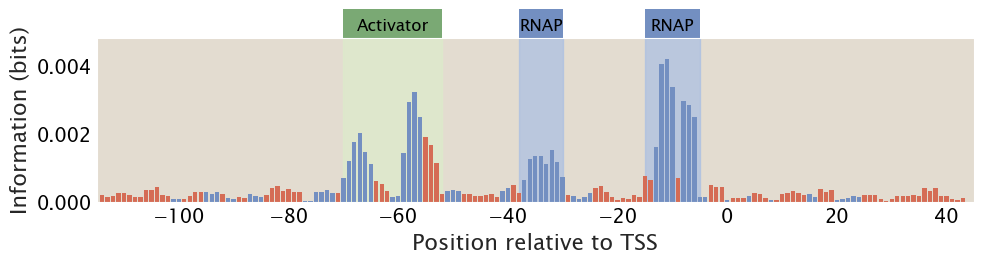

In [10]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
ea_wt = -13
e_ap = -10
cov = 10

df = tregs.simulate.sim(promoter, simact_pbound_with_noise, [rnap_site, crp_site], 
						*[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
							   annotate_stn=False,
                               outfile='../rebuttal_plots/extrinsic_noise_simact.pdf')

In [11]:
rep1_site = promoter[(115-50):(115-40)]
rep2_site = promoter[(115+15):(115+25)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [12]:
def doublerep_pbound_with_noise(p_seq, r1_seq, r2_seq, n_NS, mean_p, mean_r1, mean_r2,
					 p_emat, r1_emat, r2_emat, 
					 ep_wt, er1_wt, er2_wt, e_int_r1r2,
					 cov):
	
	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_r1, sigma_r1 = get_parameters(mean_r1, cov)
	mu_r2, sigma_r2 = get_parameters(mean_r2, cov)

	n_p = np.exp(np.random.normal(mu_p, sigma_p, 1)[0])
	n_r1 = np.exp(np.random.normal(mu_r1, sigma_r1, 1)[0])
	n_r2 = np.exp(np.random.normal(mu_r2, sigma_r2, 1)[0])

	w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
	w_r1 = tregs.simulate.get_weight(r1_seq, r1_emat, e_wt=er1_wt)
	w_r2 = tregs.simulate.get_weight(r2_seq, r2_emat, e_wt=er2_wt)

	z = np.zeros(5)
	z[0] = 1
	z[1] = n_p / n_NS * w_p
	z[2] = n_r1 / n_NS * w_r1
	z[3] = n_r2 / n_NS * w_r2
	z[4] = (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int_r1r2)
	pbound = z[1] / np.sum(z)

	return pbound

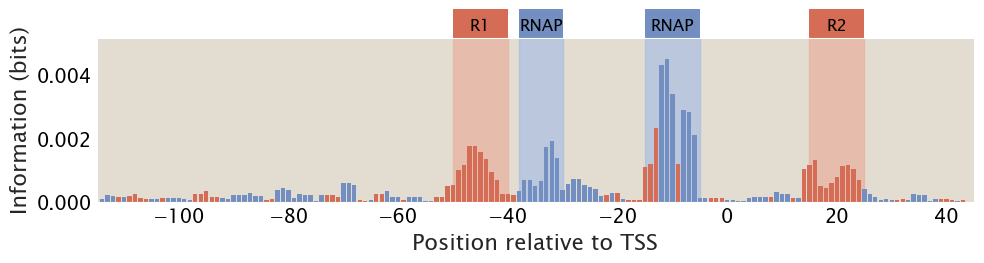

In [13]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -12, -12
e_int = -5
n_p, n_r1, n_r2 = 4600, 15, 15
cov = 10

df = tregs.simulate.sim(promoter, doublerep_pbound_with_noise, [rnap_site, rep1_site, rep2_site],
						*[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, cov],
						scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-50, -40, 'R', 'R1'), (15, 25, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
							   nbins=2, annotate_stn=False,
                               outfile='../rebuttal_plots/extrinsic_noise_doubrep.pdf')

### Double activation

In [14]:
def doubleact_pbound_with_noise(p_seq, a1_seq, a2_seq, n_NS, mean_p, mean_a1, mean_a2,
					 p_emat, a1_emat, a2_emat, 
					 ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, cov):
	
	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_a1, sigma_a1 = get_parameters(mean_a1, cov)
	mu_a2, sigma_a2 = get_parameters(mean_a2, cov)

	n_p = np.exp(np.random.normal(mu_p, sigma_p, 1)[0])
	n_a1 = np.exp(np.random.normal(mu_a1, sigma_a1, 1)[0])
	n_a2 = np.exp(np.random.normal(mu_a2, sigma_a2, 1)[0])

	w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
	w_a1 = tregs.simulate.get_weight(a1_seq, a1_emat, e_wt=ea1_wt)
	w_a2 = tregs.simulate.get_weight(a2_seq, a2_emat, e_wt=ea2_wt)

	z = np.zeros(8)
	z[0] = 1
	z[1] = n_a1 / n_NS * w_a1
	z[2] = n_a2 / n_NS * w_a2
	z[3] = (n_a1 / n_NS * w_a1) * (n_a2 / n_NS * w_a2)
	z[4] = n_p / n_NS * w_p
	z[5] = (n_p / n_NS * w_p) * (n_a1 / n_NS * w_a1) * np.exp(-e_int_pa1)
	z[6] = (n_p / n_NS * w_p) * (n_a2 / n_NS * w_a2) * np.exp(-e_int_pa2)
	z[7] = z[5] * (n_a2 / n_NS * w_a2) * np.exp(-e_int_pa2)
	pbound = np.sum(z[4:]) / np.sum(z)

	return pbound

In [15]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

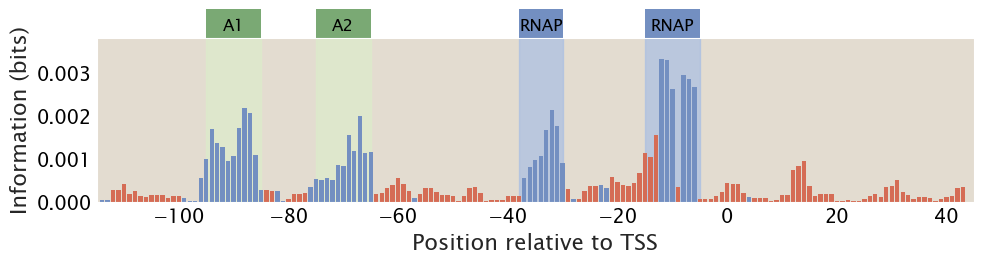

In [16]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 50, 50
cov = 10

df = tregs.simulate.sim(promoter, doubleact_pbound_with_noise, [rnap_site, act1_site, act2_site],
						*[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_pa1, e_int_pa2, e_int_a1a2, cov], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
							   nbins=2, annotate_stn=False,
                               outfile='../rebuttal_plots/extrinsic_noise_doubact.pdf')

### Repression-activation

In [17]:
def repact_pbound_with_noise(p_seq, r_seq, a_seq, n_NS, mean_p, mean_r, mean_a,
				  p_emat, r_emat, a_emat,
				  ep_wt, er_wt, ea_wt, e_int_pa, cov):
	
	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_r, sigma_r = get_parameters(mean_r, cov)
	mu_a, sigma_a = get_parameters(mean_a, cov)

	n_p = np.exp(np.random.normal(mu_p, sigma_p, 1)[0])
	n_r = np.exp(np.random.normal(mu_r, sigma_r, 1)[0])
	n_a = np.exp(np.random.normal(mu_a, sigma_a, 1)[0])

	w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
	w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)
	w_a = tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)

	z = np.zeros(5)
	z[0] = 1
	z[1] = n_p / n_NS * w_p
	z[2] = n_r / n_NS * w_r
	z[3] = n_a / n_NS * w_a
	z[4] = (n_p / n_NS * w_p) * (n_a / n_NS * w_a) * np.exp(-e_int_pa)
	
	return (z[1] + z[4]) / np.sum(z)

In [18]:
act_site = promoter[(115 - 110 + 40):(115 - 110 + 55)]
rep_site = promoter[(115+5):(115+20)]

act_emat = tregs.simulate.generate_emap(act_site, fixed=True, fixed_value=1)
rep_emat = tregs.simulate.generate_emap(rep_site, fixed=True, fixed_value=1)

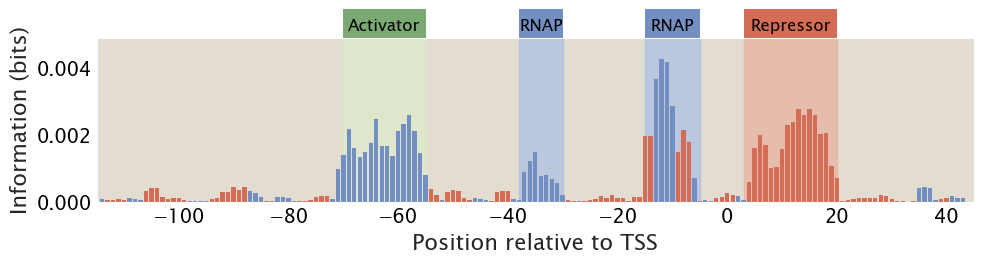

In [19]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -15, -12
e_int = -8
n_p, n_r, n_a = 4600, 50, 50
cov = 10

df = tregs.simulate.sim(promoter, repact_pbound_with_noise, [rnap_site, rep_site, act_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, act_emat, ep_wt, er_wt, ea_wt, e_int, cov], scaling_factor=10*6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'),
                 (-70, -55, 'A', 'Activator'), (3, 20, 'R', 'Repressor')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../rebuttal_plots/extrinsic_noise_repact.pdf')